# Nonlinear Impulse Response Functions

In [1]:
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 11.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

from sklearn.linear_model import LinearRegression
import random
from datetime import datetime

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = 'drive/MyDrive/EconML DL/Fall 2021'

In [ ]:
# 3-variable quarterly (new)
data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
data['quarter'] = ((data['trend'] ) / 3).astype(int)
dates = data.groupby('quarter')['Unnamed: 0'].last()
data = data.groupby('quarter').mean().reset_index()
data['L0_HOUST'] = data['L0_HOUST'].diff()
data = data.dropna()

# Exclude COVID
data = data.iloc[:-8, :]
x_d = data[['L0_TB3MS', 'L_0y', 'L0_UNRATE']]
x_d.columns = ['Interest', 'Inf', 'Unemp']
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

In [4]:
# Loading the Data - 7-variables Monthly

data = pd.read_csv('drive/MyDrive/EconML DL/Forecasting/monthlyData.csv')
x_d_all = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d_all['L0_HOUST'] = x_d_all['L0_HOUST'].diff()
x_d_all = x_d_all.dropna()
x_d_all.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

# Get down to 3 variables
x_d = x_d_all[['inf', 'unrate', 'DGS3']]
x_d = x_d[['DGS3', 'inf', 'unrate']]
x_d.columns = ['Interest', 'Inf', 'Unemp']
x_d = x_d.iloc[:-20, :]
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
data = pd.read_csv('drive/MyDrive/EconML DL/ryan_data_h1.csv')
data = data.dropna()
x_d = data[['Y_sp', 'Y_nas', 'Y_vix', 'Y_dj']]
x_d.columns = ['S&P', 'NASDAQ', 'VIX', 'DJIA']
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

## (Optional) Generating Linear IRFs from Simulated VAR

In [ ]:
sim_n_obs = 200
n_var = 3

sim_resid = np.random.randn(sim_n_obs, 3) * 0.2
#sim_resid[1:, :] = sim_resid[1:, :] * 0.2
sim_data = np.zeros((sim_n_obs, 3))
sim_data[:] = np.nan

# Autocorrelation coefficients
ar_coef = np.hstack(
    [np.expand_dims(np.linspace(0.9, 0.3, sim_n_obs), 1),
     np.expand_dims(np.linspace(0.9, 0.3, sim_n_obs), 1),
     np.expand_dims(np.linspace(0.9, 0.3, sim_n_obs), 1)
    ])

sim_data[0, :] = sim_resid[0, :]

for i in range(1, sim_n_obs):
  for var in range(n_var):
    sim_data[i, var] = sim_data[i-1, var] * ar_coef[i, var] + sim_resid[i, var]

x_d = pd.DataFrame(sim_data)
x_d.columns = ['inflation', 'unrate', 'interest']

In [ ]:
import statsmodels

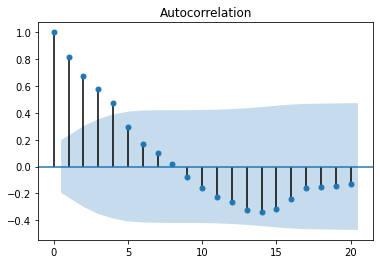

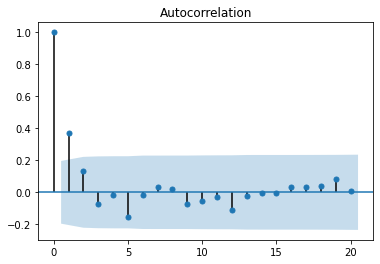

In [ ]:
a = statsmodels.graphics.tsaplots.plot_acf(x_d.iloc[0:100, 1])
a = statsmodels.graphics.tsaplots.plot_acf(x_d.iloc[100:200, 1])

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.vector_ar.svar_model import SVARProcess, VARProcess
#import statsmodels as sm

In [ ]:
# Generate Simulated Data

# ar1 = np.array([1, -0.8])
# ma1 = np.array([1])
# AR_object1 = ArmaProcess(ar1, ma1)
# simulated_data_1 = AR_object1.generate_sample(nsample = x_d.shape[0])

# ar2 = np.array([1, -0.7])
# ma2 = np.array([1])
# AR_object2 = ArmaProcess(ar2, ma2)
# simulated_data_2 = AR_object1.generate_sample(nsample = x_d.shape[0])

# x_d['inf'] = simulated_data_1
# x_d['lclaim_int'] = simulated_data_2

In [ ]:
# Create a Structural VAR process

# p (n_lags) x k (n_vars) x k
var_coefs = np.array([[[0.8, 0.7],
                       [0.0, 0.7]]])
var_sigma_u = np.array([[1, 0.0],
                         [0.0, 1]])

var = VARProcess(var_coefs, None, var_sigma_u)

sim = var.simulate_var(steps = x_d.shape[0], offset = None)

x_d['inf'] = sim[:, 0]
x_d['lclaim_int'] = sim[:,1]

In [ ]:
# Plot the generated data
plt.plot(x_d.iloc[0:200, 0], label = 'inf')
plt.plot(x_d.iloc[0:200, 1], label = 'lclaim_int')
plt.legend()

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
# Estimate the VAR so we can do impulse responses
var_model_estimated = VAR(x_d)
var_fit = var_model_estimated.fit(4)
var_fit.summary()

In [ ]:
# Plot the IRFs
irf = var_fit.irf(20)
irf_plot = irf.plot(orth = False)

In [ ]:
irf_plot = irf.plot_cum_effects(orth = False)

## Evaluating IRF graphs for VARNN

In [ ]:
# Load the Data (OLD)

experiment_name = '26may_unconditional_irf'
folder_path = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}'
# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

for i in range(1):
  saved_dir = f'drive/MyDrive/EconML DL/2022 Experiments/{experiment_name}/fcast_{i}.npy'
  if i == 0:
    FCAST = np.load(saved_dir)
  else:
    FCAST_batch = np.load(saved_dir)
    FCAST = np.vstack([FCAST, FCAST_batch])

endh = 50
num_outer_bootstraps = FCAST.shape[0]
num_simulations = FCAST.shape[1]
n_var = FCAST.shape[3]
irf_mat = np.zeros((n_var, n_var, endh, 3))
# Start shocking from period 20
randoms = list(range(100, num_simulations, endh))

In [ ]:
# Load the Data (NEW)

experiment_name = '28jun_unconditional_irf_monthly'
folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

saved_dir = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp0_repeat_0.npz'
out = np.load(saved_dir, allow_pickle = True)
FCAST = out['fcast']
FCAST_COV_MAT = out['fcast_cov_mat']
FCAST = np.expand_dims(FCAST, axis = 0)

endh = 50
num_outer_bootstraps = FCAST.shape[0]
num_simulations = FCAST.shape[1]
n_var = FCAST.shape[3]
irf_mat = np.zeros((n_var, n_var, endh, 3))
# Start shocking from period 20
randoms = list(range(40, num_simulations, endh))

In [5]:
# Load the Data (NEW)

experiment_name = '28jun_unconditional_irf_monthly'
folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

In [7]:
# Code to Combine Results from Multiple Repeats

# dictionary of keys to keep and the dimension of bootstrap
keys_to_keep = {'fcast': 0,
                'fcast_cov_mat': 0}

# Load the repeat0 file
out = np.load(f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp1_repeat0.npz', allow_pickle = True)

out_all = {k:(np.expand_dims(v, axis = 0)) for k,v in out.items() if k in keys_to_keep.keys()}

i = 1
# While there are more repeats to process, stack the fields
while os.path.exists(f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp1_repeat{i}.npz') and i < 5:
  print(i)
  out = np.load(f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp1_repeat{i}.npz', allow_pickle = True)
  
  for k, v in out_all.items():
    out_all[k] = np.concatenate([out_all[k], np.expand_dims(out[k], axis = 0)], axis = keys_to_keep[k])      
  i += 1

with open(f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp1_compiled.npz', 'wb') as f:
    np.savez(f, **out_all)

1
2
3
4


In [15]:
# Load the Data (NEW)

experiment_name = '28jun_unconditional_irf_monthly'
folder_path = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}'
# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

saved_dir = f'drive/MyDrive/EconML DL/New Experiments/{experiment_name}/fcast_exp0_compiled.npz'
out = np.load(saved_dir, allow_pickle = True)
FCAST = out['fcast']
FCAST_COV_MAT = out['fcast_cov_mat']
#FCAST = np.expand_dims(FCAST, axis = 0)

endh = 50
num_outer_bootstraps = FCAST.shape[0]
num_simulations = FCAST.shape[1]
n_var = FCAST.shape[3]
irf_mat = np.zeros((n_var, n_var, endh, 3))
# Start shocking from period 20
randoms = list(range(40, num_simulations, endh))

In [17]:
# Remove exploding values
explode_indices = np.argwhere(np.abs(FCAST) > 5)
start_index_to_remove_list = pd.DataFrame(explode_indices).groupby(0)[1].min()
for i, start_index_to_remove in start_index_to_remove_list.iteritems():
  print(i, start_index_to_remove)

  FCAST[i, start_index_to_remove:, :, :, :] = np.nan

0 301
1 811
4 183


In [18]:
# Calculate the difference in the variable values with shock and without shock

# Fcast: (bootstrap num x num inner shocks x timestep x response var x shock var x shock level)
DIFF = np.zeros((num_outer_bootstraps, len(randoms) -1, endh, n_var, n_var))
DIFF[:] = np.nan

for kk in range(n_var): # Shock variable
  for k in range(n_var): # Response variable
    for h in range(endh):
      # Get the indices of same horizon to average from
      those = [e + h for e in randoms if e + h < num_simulations]
      #if len(those) == len(randoms):
        # difference in the forecasts
      DIFF[:, :, h, k, kk] = FCAST[:, those[:(len(randoms) -1)], k, kk, 1] - FCAST[:, those[:(len(randoms) -1)], k, kk, 0]

# Get the cumulative differences
CUM_DIFF = np.cumsum(DIFF, axis = 2)

In [19]:
# Get the IRFs and cumulative IRFs

irf_mat = np.zeros((n_var, n_var, endh, 3))

for kk in range(n_var): # Shock variable
  for k in range(n_var): # Response variable
    for h in range(endh):
      # Get the indices of same horizon to average from
      # difference in the forecasts
      irf_mat[kk, k, h, 0] = np.nanquantile(DIFF[:, :, h, k, kk], q = 0.16)
      irf_mat[kk, k, h, 1] = np.nanquantile(DIFF[:, :, h, k, kk], q = 0.5)
      irf_mat[kk, k, h, 2] = np.nanquantile(DIFF[:, :, h, k, kk], q = 0.84)

irf_cum_mat = np.zeros((n_var, n_var, endh, 3))

for kk in range(n_var): # Shock variable
  for k in range(n_var): # Response variable
    for h in range(endh):
      # Get the indices of same horizon to average from
      # difference in the forecasts
      irf_cum_mat[kk, k, h, 0] = np.nanquantile(CUM_DIFF[:, :, h, k, kk], q = 0.16)
      irf_cum_mat[kk, k, h, 1] = np.nanquantile(CUM_DIFF[:, :, h, k, kk], q = 0.5)
      irf_cum_mat[kk, k, h, 2] = np.nanquantile(CUM_DIFF[:, :, h, k, kk], q = 0.84)

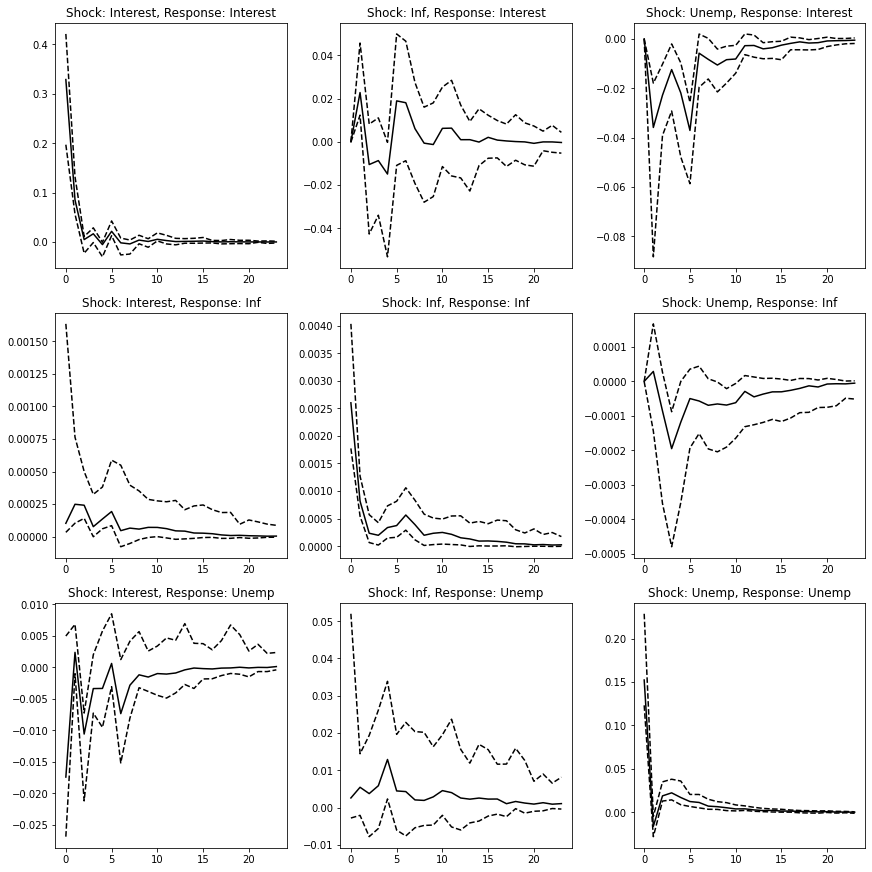

In [25]:
# Plot IRFs
h = 24

fig, axs = plt.subplots(n_var, n_var, figsize = (4 * n_var, 4 * n_var), constrained_layout = True)

#var_names = ['Interest', 'Inf', 'Unemp']
for shock_var in range(n_var):

  for response_var in range(n_var):
    
    # Plot median
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 1], lw = 1.5, color = 'black')

    #Plot all bootstraps 
    # for b in range(num_outer_bootstraps):
    #   for r in range(len(randoms) - 1):
    #     axs[response_var, shock_var].plot(DIFF[b, r, :h, response_var, shock_var], lw = 0.5, alpha = 0.2)

    # Plot confidence bands
    #axs[response_var, shock_var].fill_between(range(h), irf_mat[shock_var, response_var, :h, 0], irf_mat[shock_var, response_var, :h, 2], alpha = 0.5)

    # Plot confidence bands
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 0], lw = 1.5, color = 'black', ls = '--')
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 2], lw = 1.5, color = 'black', ls = '--')

    axs[response_var, shock_var].set_title(f'Shock: {var_names[shock_var]}, Response: {var_names[response_var]}')
    #axs[response_var, shock_var].set_xlabel('Periods')
    #axs[response_var, shock_var].set_ylabel('Impulse Response')
    #axs[response_var, shock_var].set_ylim((-0.5, 1))

    # axs[response_var, shock_var].set_ylim(
    #         np.nanmin(np.nanquantile(DIFF[:, r, :, response_var, shock_var], q = 0.0001)),
    #         np.nanmax(np.nanquantile(DIFF[:, r, :, response_var, shock_var], q = 0.9999))
    #     )

plt.savefig(f'{image_folder_path}/irf.png')

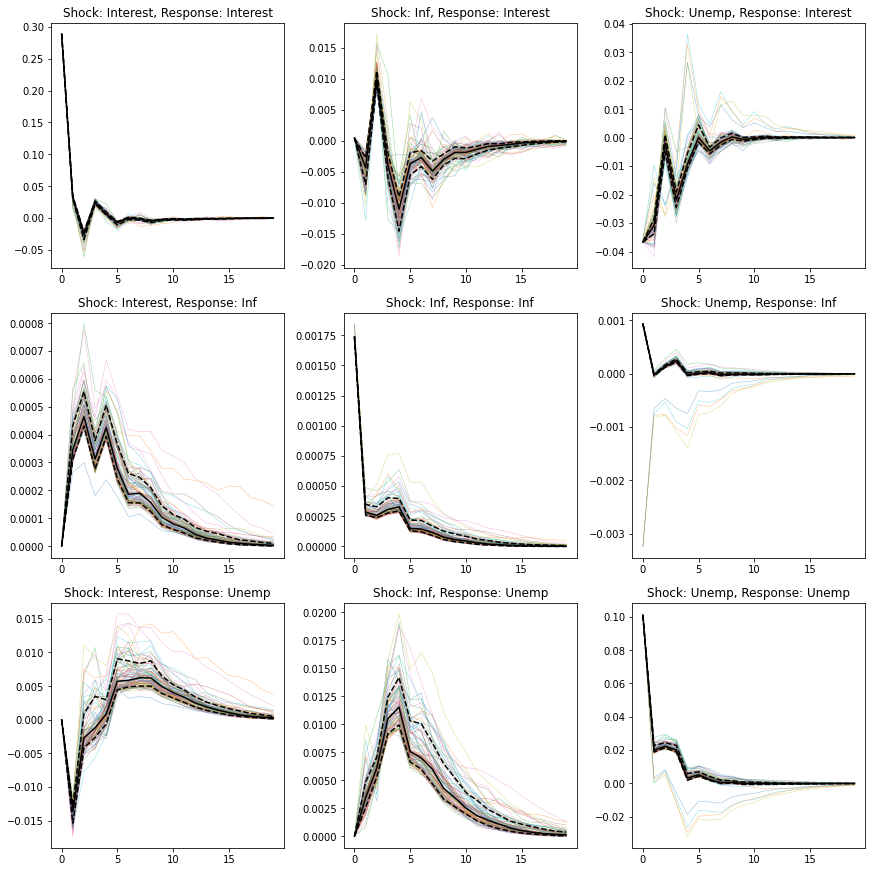

In [ ]:
# Plot IRFs
h = 24

fig, axs = plt.subplots(n_var, n_var, figsize = (4 * n_var, 4 * n_var), constrained_layout = True)

var_names = ['Interest', 'Inf', 'Unemp']
for shock_var in range(n_var):

  for response_var in range(n_var):

    # Plot all bootstraps 
    for b in range(num_outer_bootstraps):
      for r in range(len(randoms)):
        axs[response_var, shock_var].plot(DIFF[b, r, :h, response_var, shock_var], lw = 0.5, alpha = 0.5)

    # Plot median
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 1], lw = 1.5, color = 'black')

    # Plot confidence bands
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 0], lw = 1.5, color = 'black', ls = '--')
    axs[response_var, shock_var].plot(irf_mat[shock_var, response_var, :h, 2], lw = 1.5, color = 'black', ls = '--')

    axs[response_var, shock_var].set_title(f'Shock: {var_names[shock_var]}, Response: {var_names[response_var]}')

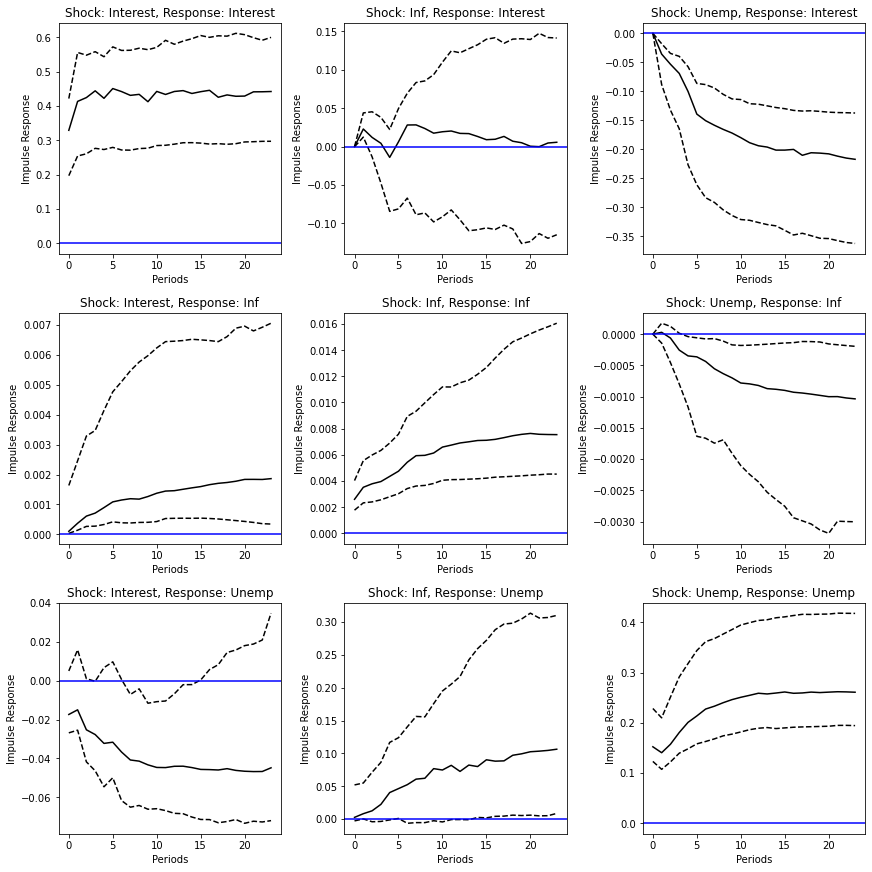

In [26]:
# Plot Cumulative IRFs 
h = 24

fig, axs = plt.subplots(n_var, n_var, figsize = (4 * n_var, 4 * n_var), constrained_layout = True)
#var_names = ['Interest', 'Inf', 'Unemp']

for shock_var in range(n_var):
  for response_var in range(n_var):
    
    # Plot median
    axs[response_var, shock_var].plot(irf_cum_mat[shock_var, response_var, :h, 1], color = 'black', lw = 1.5)

    # Plot all bootstraps 
    # for b in range(num_outer_bootstraps):
    #   for r in range(len(randoms) - 1):
    #     axs[response_var, shock_var].plot(CUM_DIFF[b, r, :h, response_var, shock_var], lw = 0.5, alpha = 0.5)

    # Plot confidence bands
    #axs[response_var, shock_var].fill_between(range(h), irf_cum_mat[shock_var, response_var, :h, 0], irf_cum_mat[shock_var, response_var, :h, 2], alpha = 0.5)
    axs[response_var, shock_var].plot(irf_cum_mat[shock_var, response_var, :h, 0], lw = 1.5, color = 'black', ls = '--')
    axs[response_var, shock_var].plot(irf_cum_mat[shock_var, response_var, :h, 2], lw = 1.5, color = 'black', ls = '--')

    axs[response_var, shock_var].axhline(y = 0, color = 'blue')
    axs[response_var, shock_var].set_title(f'Shock: {var_names[shock_var]}, Response: {var_names[response_var]}')
    axs[response_var, shock_var].set_xlabel('Periods')
    axs[response_var, shock_var].set_ylabel('Impulse Response')
    #axs[response_var, shock_var].set_ylim((-0.5, 1))

plt.savefig(f'{image_folder_path}/cum_irf.png')

### VAR Benchmark

In [28]:
from statsmodels.tsa.api import VAR

In [28]:
var_model = VAR(x_d.iloc[100:, :])
var_results = var_model.fit(10)
irf = var_results.irf(30)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [29]:
var_model = VAR(x_d.iloc[12:, :])
var_results = var_model.fit(6)
irf = var_results.irf(24)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


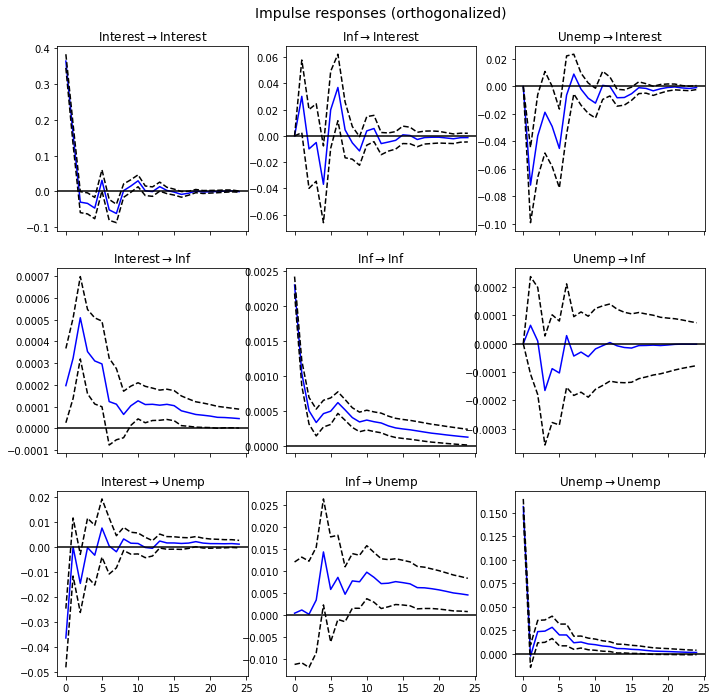

In [30]:
irf_plot = irf.plot(orth = True)

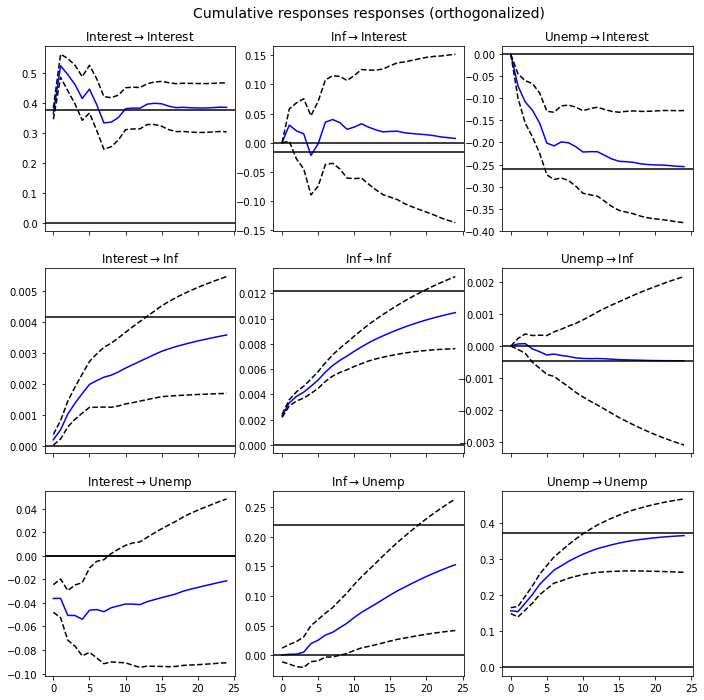

In [31]:
cum_irf_plot = irf.plot_cum_effects(orth = True)